# import

In [180]:
from collections import Counter

from sklearn import feature_selection
from sklearn.feature_selection import SelectPercentile
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.decomposition import PCA

from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import classification_report, accuracy_score

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import pymrmr

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset

In [17]:
### Generates a random n-class classification dataset problem ###
X, y = make_classification(n_classes=2,
                           class_sep=2,
                           weights=[0.1, 0.9],
                           n_informative=3,
                           n_redundant=1,
                           flip_y=0,
                           n_features=20,
                           n_clusters_per_class=1,
                           n_samples=1000,
                           random_state=10)

print('Original dataset shape {}'.format(Counter(y)))

Original dataset shape Counter({1: 900, 0: 100})


# With and without Pipeline - Example 1

In [6]:
### Using imblearn Pipeline ###
# Pipeline assembles several steps that can cross validated together 
# It sequentially applies a list of transforms, sampling, and a final estimator
pca = PCA()
smote = SMOTE(random_state=42)
knn = KNN()
pipeline = Pipeline ([('smote', smote), ('pca', pca), ('knn', knn)])

X_train, X_test, y_train, y_test = tts(X,y,random_state=42)

pipeline.fit(X_train, y_train)

y_hat = pipeline.predict(X_test)
print ("Classification accuracy:",accuracy_score(y_test, y_hat))

Classification accuracy: 0.984


In [7]:
### Using traditional approach - No pipeline##
X_pca2 = PCA(random_state=42).fit_transform(X)

X_train2, X_test2, y_train2, y_test2 = tts(X_pca2, y, random_state=42)
#print (X_train2.shape, Counter(y_train2))

X_smote2, y_smote2 = SMOTE(random_state=42).fit_resample(X_train2, y_train2)
#print (X_smote2.shape, Counter(y_smote2))

knn2 = KNN().fit(X_smote2, y_smote2)
y_hat2 = knn2.predict(X_test2)
print("Classification accuracy:", accuracy_score(y_test2, y_hat2))

Classification accuracy: 0.984


# StratifiedKFold CVGridSearch - Example 2

In [166]:
pca = PCA()
smote = SMOTE(random_state=42)
classifier = KNN()
pipeline = Pipeline([('smote', smote),
                     ('feat_sel',
                      SelectPercentile(feature_selection.f_classif)),
                     ('classifier', SVC())])

para_steps = {}
para_steps.update({
    'feat_sel': [SelectPercentile(feature_selection.f_classif)],
    'feat_sel' + '__percentile': [20]
})
# para_steps.update({
#     'classifier': [classifier],
#     'classifier' + '__n_neighbors' : [5,7,9]
# })
para_steps.update({
    'classifier': [SVC()],
    'classifier' + '__kernel': ['linear'],  # 'rbf'],
    'classifier' + '__C': [0.1],  #, 0.5, 1],
})

param_grid = para_steps

skf = StratifiedKFold(n_splits=4, random_state=42)

grid = GridSearchCV(pipeline,
                    cv=skf,
                    n_jobs=-1,
                    param_grid=param_grid,
                    return_train_score="False")

grid.fit(X_train, y_train)

best_classifier, best_evaluator = grid.best_params_[
    'classifier'], grid.best_params_['feat_sel']
best_score = grid.best_score_

print("Best Classifier:", best_classifier)
print("Best feature sel:", best_evaluator)
print("Best CV score on training data:", best_score)

df_cv_results_ = pd.DataFrame(grid.cv_results_)
print(df_cv_results_.shape)
print("Test score rank:", grid.cv_results_['rank_test_score'])
df_cv_results_

Best Classifier: SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)
Best feature sel: SelectPercentile(percentile=20,
         score_func=<function f_classif at 0x7f7dbc34fa60>)
Best CV score on training data: 0.9933333333333333
(1, 23)
Test score rank: [1]


,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_classifier,param_classifier__C,param_classifier__kernel,param_feat_sel,param_feat_sel__percentile,params,...,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.007755,0.000839,0.993333,0.993334,"SVC(C=0.1, cache_size=200, class_weight=None, ...",0.1,linear,"SelectPercentile(percentile=20,\n scor...",20,"{'classifier': SVC(C=0.1, cache_size=200, clas...",...,0.984043,0.994662,0.989305,0.994671,1.0,0.991119,0.001809,0.000172,0.006921,0.001472


In [218]:
pipeline = Pipeline([('smote', smote), ('feat_sel', best_evaluator),
                     ('classifier', best_classifier)])
pipeline.fit(X_train, y_train)

print ('Top features:', pipeline.named_steps['feat_sel'].get_support(indices=True))

pred_class = pipeline.predict(X_test)
print ('Test accuracy:', accuracy_score(y_test, pred_class))

Top features: [ 1  5  6 10]
Test accuracy: 0.992


## Feature Selection - Manual

In [311]:
F, pval = feature_selection.f_classif(X_train, y_train)

print("F-value rank (ascending):", F.argsort())  # higher is better
print("p-value rank (ascending):", pval.argsort())  # lower is better

F-value rank (ascending): [19  3  4 17 13 11  8  2  7  9  0 12 18 15 16 14  1  5  6 10]
p-value rank (ascending): [10  6  5  1 14 16 15 18 12  0  9  7  2  8 11 13 17  4  3 19]


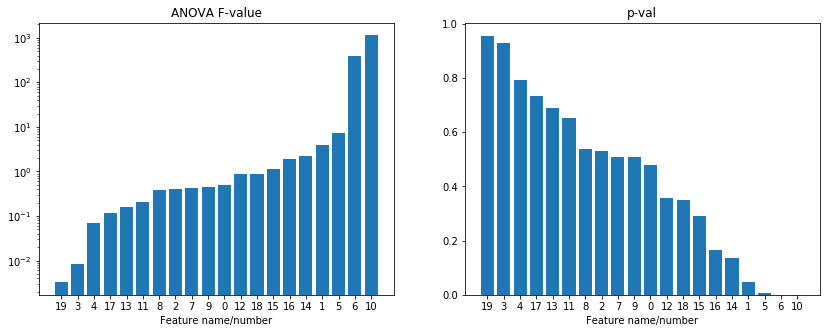

In [219]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(F)), (np.sort(F)), log=True)
plt.xticks(np.arange(len(F)), F.argsort())
plt.title('ANOVA F-value')
plt.xlabel('Feature name/number')

plt.subplot(1, 2, 2)
plt.bar(range(len(pval)), (np.sort(pval))[::-1])
plt.xticks(np.arange(len(pval)), pval.argsort()[::-1])
plt.title('p-val')
plt.xlabel('Feature name/number')

plt.show()

In [157]:
selector = SelectPercentile(feature_selection.f_classif, 10)
selector.fit(X_train, y_train)
selector.pvalues_.argsort()

array([10,  6,  5,  1, 14, 16, 15, 18, 12,  0,  9,  7,  2,  8, 11, 13, 17,
        4,  3, 19])

In [271]:
def feature_rank_manual(X_train, y_train):
    '''
    The functions returns the p-value generated e
    '''
    F, pval = feature_selection.f_classif(X_train, y_train)
    return (None, pval)

# Need to feed in a function that returns p-value for the SelectPercentile
# lower p-value is better ranked feature
selector = SelectPercentile(feature_rank_manual, percentile=10)
selector.fit(X_train, y_train)
selector.pvalues_.argsort()

array([10,  6,  5,  1, 14, 16, 15, 18, 12,  0,  9,  7,  2,  8, 11, 13, 17,
        4,  3, 19])

## MRMR feature selection

In [322]:
def feature_rank_manual(X_train, y_train):
    '''
    The functions returns the p-value equivalent (rank) generated using MRMR feature selection technique
    '''
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    df = pd.DataFrame(X_train, columns =[str(i) for i in range(X_train.shape[1])])
    df.insert(loc=0,column='Class', value=y_train)
    rank= pymrmr.mRMR(df, 'MID', X_train.shape[1])
    rank = [int(i) for i in rank]
    pval_eq = np.arange(len(rank))
    mrmr = np.arange(len(rank))

    for i in range(len(rank)):
        pval_eq[rank[i]] = i
        mrmr[rank[i]]=len(rank)-i-1
    return (mrmr, pval_eq)

# Need to feed in a function that returns p-value for the SelectPercentile
# lower p-value is better ranked feature
selector = SelectPercentile(feature_rank_manual, percentile=10)
selector.fit(X_train, y_train)
selector.pvalues_.argsort()

array([10, 15,  9,  6,  5,  0,  7, 11, 13,  8, 18, 17,  4,  1, 14,  3, 16,
        2, 12, 19])

In [321]:
df = pd.DataFrame(X_train, columns =[str(i) for i in range(20)])
df.insert(loc=0,column='Class', value=y_train)
df

rank = (pymrmr.mRMR(df, 'MID',  X_train.shape[1]))
rank = [int(i) for i in rank]
print ('Actual rank of features:', rank)

pval_eq = np.arange(len(rank))
mrmr = np.arange(len(rank))
for i in range(len(rank)):
    pval_eq[rank[i]] = i
    mrmr[rank[i]]=len(rank)-i-1
print ('MRMR rank:', mrmr.argsort())
print ('P value alike:', pval_eq.argsort())

Actual rank of features: [10, 15, 9, 6, 5, 0, 7, 11, 13, 8, 18, 17, 4, 1, 14, 3, 16, 2, 12, 19]
MRMR rank: [19 12  2 16  3 14  1  4 17 18  8 13 11  7  0  5  6  9 15 10]
P value alike: [10 15  9  6  5  0  7 11 13  8 18 17  4  1 14  3 16  2 12 19]


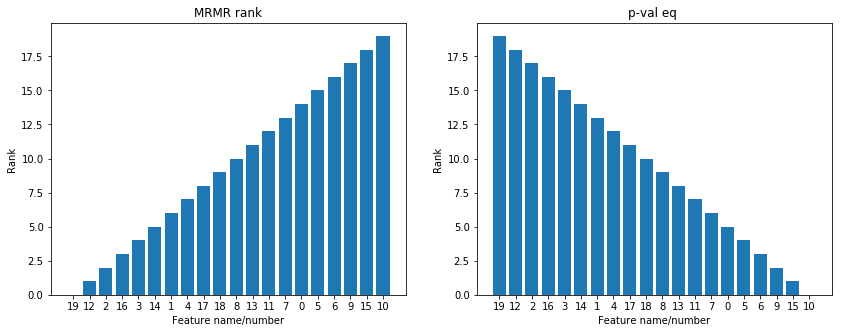

In [319]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.bar(range(len(mrmr)), (np.sort(mrmr)), log=False)
plt.xticks(np.arange(len(mrmr)), mrmr.argsort())
plt.title('MRMR rank')
plt.xlabel('Feature name/number')
plt.ylabel('Rank')

plt.subplot(1, 2, 2)
plt.bar(range(len(pval_eq)), (np.sort(pval_eq))[::-1])
plt.xticks(np.arange(len(pval_eq)), pval_eq.argsort()[::-1])
plt.title('p-val eq ')
plt.xlabel('Feature name/number')
plt.ylabel('Rank')

plt.show()